In [1]:

import tifffile
import numpy as np
import os
import cv2
import json
import time
import pandas as pd

# import seaborn as sns
from scipy import stats
import gc
from tifffile import TiffFile
# from skimage import io
import tifffile
from scipy.ndimage import zoom
import traceback
import gzip
import shutil
from scipy.stats import pearsonr

import random
from joblib import Parallel, delayed
from numba import jit
from statsmodels.stats.multitest import multipletests

import math

import cfospy
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap, BoundaryNorm, ListedColormap, hsv_to_rgb
from multiprocessing import Pool
plt.gray()

import json, os.path, os, re, time
# import joblib
import subprocess as sp
import nibabel as nib
import scipy.spatial
from scipy.signal import convolve

/mnt/gpu_data/data1/kinoshita


<Figure size 640x480 with 0 Axes>

In [3]:
# cfos_fol="/mnt/data1/yamashitaData1/231012_circadian_2nd_Data1/231012_circadian_2nd_Reconst/"
# exp = "2nd"
pre_root = "/mnt/"

src = pre_root+"/gpu_data/data1/kinoshita/"
dst = pre_root+"/gpu_data/data8/kinoshita_cfos/"


cfos_fol = pre_root+ "/gpu_data/data1//yamashitaData1/230828circadian_Data1/230828circadian_1st_Reconst/"
exp = "1st"
savedir = dst + "/cfos_app/"

CT_li = np.arange(0,48,4)
sample_ids = np.arange(1,7,1)

reconsts = os.listdir(cfos_fol)
sample_names=[]
colors=[]
data_parent_paths=[]
data_moving_paths =[]

for CT in CT_li:
#     if CT<44:
#         continue
    for sample_id in sample_ids:
#         if sample_id >1:
#             continue
        sample = "CT"+str(CT)+"_"+str(sample_id).zfill(2)

        for reconst in reconsts:
#             sample_names.append(("_").join(reconst.split("_")[1:3]))

            if sample in reconst:
                sample_names.append(sample)
                for color in os.listdir(cfos_fol+reconst):
                    if "cfos" in color:
                        data_moving_paths.append(cfos_fol+reconst+"/"+color)
                    else:
                        data_parent_paths.append(cfos_fol+reconst+"/"+color)

print(len(data_parent_paths))   
print(len(data_moving_paths))
print(len(sample_names))

72
72
72


In [4]:
#load atlas data

import cfospy
vx=50
rdir = "/mnt/gpu_data/data1/kinoshita/CUBIC_R_atlas_ver5_scn/"

ca=cfospy.analysis.read_atlas_data(rdir, vx)

print(len(ca.ID_all))


   

voxel_num: 36245880
837


In [5]:
#functions

def calc_CT_norm(CT_df, th):
    CTs =np.arange(0, 24*1,4)
    num_samp=6
    CT_mean_li = np.zeros(len(CTs))

    
    df_i=CT_df[CT_df["BH.Q"]<th]
    ids = df_i["id"].tolist()


    print("num of regions:", len(df_i))


    name_li = []
    for rID in df_i["id"]:
        name_li.append(CT_df[CT_df["id"]==rID]["acronym"].iloc[0])
        
    df_all = np.array(df_i.iloc[:,9:])
    

    #z 
    df_i = (df_all-np.mean(df_all, axis=1).reshape(-1,1))/(np.std(df_all, axis=1).reshape(-1,1))
    
    
    CT_ms = np.zeros((len(df_i),len(CTs)))
    CT_sds = np.zeros((len(df_i),len(CTs)))
    for CT_i in range(len(CTs)):
#         if CT_i>0:
#             continue
        CT_li = np.array((df_i[:, CT_i*num_samp:(CT_i+1)*num_samp]))
        CT_li = CT_li + np.array( (df_i[:, CT_i*num_samp+6*6:(CT_i+1)*num_samp+6*6]))
        CT_li = CT_li + np.array((df_i[:, CT_i*num_samp+6*6*2:(CT_i+1)*num_samp+6*6*2]))
        CT_li = CT_li + np.array((df_i[:, CT_i*num_samp+6*6*3:(CT_i+1)*num_samp+6*6*3]))
        CT_li = CT_li/4
        
#         print(CT_li)
        
        CT_ms[:,CT_i] = np.mean(CT_li, axis=1)
        CT_sds[:,CT_i] = np.std(CT_li, axis=1) #  /np.sqrt(num_samp)

    return ids, df_i,  CT_ms


def calc_CT_norm_exp(CT_df, th, exp):
    CTs =np.arange(0, 24*1,4)
    num_samp=6
    CT_mean_li = np.zeros(len(CTs))

    
    df_i=CT_df[CT_df["BH.Q"]<th]
    ids = df_i["id"].tolist()


    print("num of regions:", len(df_i))


    name_li = []
    for rID in df_i["id"]:
        name_li.append(CT_df[CT_df["id"]==rID]["acronym"].iloc[0])
        
    df_all = np.array(df_i.iloc[:,9:])
    

    #z 
    df_i = (df_all-np.mean(df_all, axis=1).reshape(-1,1))/(np.std(df_all, axis=1).reshape(-1,1))
    
    
    CT_ms = np.zeros((len(df_i),len(CTs)))
    CT_sds = np.zeros((len(df_i),len(CTs)))
    for CT_i in range(len(CTs)):
#         if CT_i>0:
#             continue
        if exp=="1st":
            CT_li = np.array((df_i[:, CT_i*num_samp:(CT_i+1)*num_samp]))
            CT_li = CT_li + np.array( (df_i[:, CT_i*num_samp+6*6:(CT_i+1)*num_samp+6*6]))
        elif exp=="2nd":
            CT_li =  np.array((df_i[:, CT_i*num_samp+6*6*2:(CT_i+1)*num_samp+6*6*2]))
            CT_li = CT_li + np.array((df_i[:, CT_i*num_samp+6*6*3:(CT_i+1)*num_samp+6*6*3]))
        CT_li = CT_li/2
        
#         print(CT_li)
        
        CT_ms[:,CT_i] = np.mean(CT_li, axis=1)
        CT_sds[:,CT_i] = np.std(CT_li, axis=1) #  /np.sqrt(num_samp)

    return ids, df_i,  CT_ms


def calc_CT_norm_exp_day(CT_df, th, exp, day):
    CTs =np.arange(0, 24*1,4)
    num_samp=6
    CT_mean_li = np.zeros(len(CTs))

    df_i=CT_df[CT_df["BH.Q"]<th]
    ids = df_i["id"].tolist()

    print("num of regions:", len(df_i))

    name_li = []
    for rID in df_i["id"]:
        name_li.append(CT_df[CT_df["id"]==rID]["acronym"].iloc[0])
        
    df_all = np.array(df_i.iloc[:,9:])
    #z 
    df_i = (df_all-np.mean(df_all, axis=1).reshape(-1,1))/(np.std(df_all, axis=1).reshape(-1,1))
    
    CT_ms = np.zeros((len(df_i),len(CTs)))
    CT_sds = np.zeros((len(df_i),len(CTs)))
    for CT_i in range(len(CTs)):
#         if CT_i>0:
#             continue
        if exp=="1st" and day=="1":
            CT_li = np.array((df_i[:, CT_i*num_samp:(CT_i+1)*num_samp]))
        elif exp=="1st" and day=="2":
            CT_li = np.array( (df_i[:, CT_i*num_samp+6*6:(CT_i+1)*num_samp+6*6]))
        elif exp=="2nd" and day=="1":
            CT_li =  np.array((df_i[:, CT_i*num_samp+6*6*2:(CT_i+1)*num_samp+6*6*2]))
        elif exp=="2nd" and day=="2":
            CT_li =  np.array((df_i[:, CT_i*num_samp+6*6*3:(CT_i+1)*num_samp+6*6*3]))
        
        CT_ms[:,CT_i] = np.mean(CT_li, axis=1)
        CT_sds[:,CT_i] = np.std(CT_li, axis=1) #  /np.sqrt(num_samp)

    return ids, df_i,  CT_ms



def calc_CT_norm2(CT_df, th):
    CTs =np.arange(0, 24*1,4)
    num_samp=6


    CT_mean_li = np.zeros(len(CTs))

#     df_i = CT_df[CT_df["id"].isin(ID_li)]
    
    df_i=CT_df[CT_df["BH.Q"]<th]
    ids = df_i["id"].tolist()

    # if query == "fdr":
    #     df_i = df_i[df_i["BH.Q"] < 0.05]

    print("num of regions:", len(df_i))
#     new_order = [i for i in ID_li if i in df_i["id"].tolist()]

#     df_i=df_i.sort_values(by='id', key=lambda x: x.map({v: i for i, v in enumerate(new_order)}))


    name_li = []
    for rID in df_i["id"]:
        name_li.append(CT_df[CT_df["id"]==rID]["acronym"].iloc[0])
        
    df_all = np.array(df_i.iloc[:,9:])
    
    #minmax
#     df_i = (4*(df_all-np.min(df_all, axis=1).reshape(-1,1))/(np.max(df_all-np.min(df_all, axis=1).reshape(-1,1), axis=1)).reshape(-1,1))-2
   
    #z 
    
    CT_ms = np.zeros((len(df_i),len(CTs)))
    CT_sds = np.zeros((len(df_i),len(CTs)))
    
    for CT_i in range(len(CTs)):
#         if CT_i>0:
#             continue
        CT_li = np.array((df_all[:, CT_i*num_samp:(CT_i+1)*num_samp]))
#         print(df_i.iloc[:, CT_i*num_samp+8+6*6:(CT_i+1)*num_samp+8+6*6])
#         print(df_i.iloc[:, CT_i*num_samp+8+6*6*2:(CT_i+1)*num_samp+8+6*6*2])
#         print(df_i.iloc[:, CT_i*num_samp+8+6*6*3:(CT_i+1)*num_samp+8+6*6*3])
        
        CT_li = CT_li + np.array( (df_all[:, CT_i*num_samp+6*6:(CT_i+1)*num_samp+6*6]))
        CT_li = CT_li + np.array((df_all[:, CT_i*num_samp+6*6*2:(CT_i+1)*num_samp+6*6*2]))
        CT_li = CT_li + np.array((df_all[:, CT_i*num_samp+6*6*3:(CT_i+1)*num_samp+6*6*3]))
        CT_li = CT_li/4
        
#         print(CT_li)
        
        CT_ms[:,CT_i] = np.mean(CT_li, axis=1)
        CT_sds[:,CT_i] = np.std(CT_li, axis=1) #  /np.sqrt(num_samp)


    
    
    CT_ms = (CT_ms-np.mean(CT_ms, axis=1).reshape(-1,1))/(np.std(CT_ms, axis=1).reshape(-1,1))
    
    return ids, df_i,  CT_ms


def calc_CT_norm_1st(CT_df, th):
    CTs =np.arange(0, 24*1,4)
    num_samp=6


    CT_mean_li = np.zeros(len(CTs))

#     df_i = CT_df[CT_df["id"].isin(ID_li)]
    
    df_i=CT_df[CT_df["BH.Q"]<th]
    ids = df_i["id"].tolist()

    # if query == "fdr":
    #     df_i = df_i[df_i["BH.Q"] < 0.05]

    print("num of regions:", len(df_i))
#     new_order = [i for i in ID_li if i in df_i["id"].tolist()]

#     df_i=df_i.sort_values(by='id', key=lambda x: x.map({v: i for i, v in enumerate(new_order)}))


    name_li = []
    for rID in df_i["id"]:
        name_li.append(CT_df[CT_df["id"]==rID]["acronym"].iloc[0])
        
    df_all = np.array(df_i.iloc[:,9:])
    
    #minmax
#     df_i = (4*(df_all-np.min(df_all, axis=1).reshape(-1,1))/(np.max(df_all-np.min(df_all, axis=1).reshape(-1,1), axis=1)).reshape(-1,1))-2
    
    #z 
    df_i = (df_all-np.mean(df_all, axis=1).reshape(-1,1))/(np.std(df_all, axis=1).reshape(-1,1))
    
    
    CT_ms = np.zeros((len(df_i),len(CTs)))
    CT_sds = np.zeros((len(df_i),len(CTs)))
    for CT_i in range(len(CTs)):
#         if CT_i>0:
#             continue
        CT_li = np.array((df_i[:, CT_i*num_samp:(CT_i+1)*num_samp]))
#         print(df_i.iloc[:, CT_i*num_samp+8+6*6:(CT_i+1)*num_samp+8+6*6])
#         print(df_i.iloc[:, CT_i*num_samp+8+6*6*2:(CT_i+1)*num_samp+8+6*6*2])
#         print(df_i.iloc[:, CT_i*num_samp+8+6*6*3:(CT_i+1)*num_samp+8+6*6*3])
        
        CT_li = CT_li + np.array( (df_i[:, CT_i*num_samp+6*6:(CT_i+1)*num_samp+6*6]))
#         CT_li = CT_li + np.array((df_i[:, CT_i*num_samp+6*6*2:(CT_i+1)*num_samp+6*6*2]))
#         CT_li = CT_li + np.array((df_i[:, CT_i*num_samp+6*6*3:(CT_i+1)*num_samp+6*6*3]))
        CT_li = CT_li/2
        
#         print(CT_li)
        
        CT_ms[:,CT_i] = np.mean(CT_li, axis=1)
        CT_sds[:,CT_i] = np.std(CT_li, axis=1) #  /np.sqrt(num_samp)

    
    
    return ids, df_i,  CT_ms


def max_corr(CT_df, vnorm, a, fig=True):
#     bs=npax = plt.gca()
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([]).arange(-np.pi, np.pi, 0.01) 
    bs=np.linspace(0, 24, 144) 

    peakt = np.array(CT_df["LAG"])

    corrs = []
    for b in bs:
        cos_p = a * np.sqrt(2)*np.cos(2*np.pi*(peakt-b)/24)
        corr, p = pearsonr(vnorm, cos_p)
        corrs.append(corr)

    bc = bs[np.argmax(corrs)]
    cmax = np.max(corrs)

#     phase = rad2ph(bc)
    
    if fig==True:
        ph_li = CT_df["LAG"]/24
        ph_li = 1-ph_li
        ph_li = [(hue + 1/3 - 1) if (hue + 1/3) > 1 else (hue + 1/3) for hue in ph_li]
        colors = [hsv_to_rgb([i, 1, 1]) for i in ph_li]
        plt.scatter(CT_df["LAG"], vnorm, c=colors)
        
        plt.plot(CT_df["LAG"], a * np.sqrt(2)*np.cos(2*np.pi*(peakt-bc)/24), color = "k")
        plt.xticks(np.arange(0,28,4))
        plt.xlim(0,24)
#     plt.ylim()
#     plt.savefig(figdir+"level_peak_time_cir_test_{}.SVG".format("CT"+str(i*4)))
        plt.show()
    
    print(bc)
    
    return cmax, bc

def max_corr_fig(CT_df, vnorm, a, exp, sample, blindness=False):
#     bs=np.arange(-np.pi, np.pi, 0.01) 
    bs=np.linspace(0, 24, 144) 

    peakt = np.array(CT_df["LAG"])

    corrs = []
    for b in bs:
        
        cos_p = a * np.sqrt(2)*np.cos(2*np.pi*(peakt-b)/24)
#         print("vnorm", vnorm)
#         print("cos_p", cos_p)
        corr, p = pearsonr(vnorm, cos_p)
        corrs.append(corr)

    bc = bs[np.argmax(corrs)]
    cmax = np.max(corrs)

#     phase = rad2ph(bc)

    

    yl=2.5
    
    if blindness==True:
        ph_li = CT_df["LAG"]/24
        rgba_float = cmap_icefire(np.array(ph_li)) #[cmap_icefire([i) for i in ph_li]
        colors = rgba_float[:, :3] 

    else:
        ph_li = CT_df["LAG"]/24
        ph_li = 1-ph_li
        ph_li = [(hue + 1/3 - 1) if (hue + 1/3) > 1 else (hue + 1/3) for hue in ph_li]
        colors = [hsv_to_rgb([i, 1, 1]) for i in ph_li]
    
    plt.figure(figsize=(6,4))
    
    plt.scatter(CT_df["LAG"], vnorm, c=colors)

    plt.plot(CT_df["LAG"], a * np.sqrt(2)*np.cos(2*np.pi*(peakt-bc)/24), color = "k")
    plt.xticks(np.arange(0,28,4))

    plt.yticks(np.arange(-yl,yl+0.1,yl))
    plt.xlim(0,24)
    plt.ylim(-yl,yl)
    ax = plt.gca()
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    

    if blindness==True:
        plt.savefig(figdir_bc+"/level_peak_time_cr_test_{}_{}.SVG".format(exp, sample))
    else:
        plt.savefig(figdir+"/level_peak_time_cr_test_{}_{}.SVG".format(exp, sample))
        
    plt.show()
    
    print(bc)
    
    return cmax, bc

def max_corr_nofig(CT_df, vnorm, a, exp, sample, blindness=False):
#     bs=np.arange(-np.pi, np.pi, 0.01) 
    bs=np.linspace(0, 24, 144) 

    peakt = np.array(CT_df["LAG"])

    corrs = []
    for b in bs:
        
        cos_p = a * np.sqrt(2)*np.cos(2*np.pi*(peakt-b)/24)
#         print("vnorm", vnorm)
#         print("cos_p", cos_p)
        corr, p = pearsonr(vnorm, cos_p)
        corrs.append(corr)

    bc = bs[np.argmax(corrs)]
    cmax = np.max(corrs)

#     phase = rad2ph(bc)

    

    yl=2.5
    
    if blindness==True:
        ph_li = CT_df["LAG"]/24
        rgba_float = cmap_icefire(np.array(ph_li)) #[cmap_icefire([i) for i in ph_li]
        colors = rgba_float[:, :3] 

    else:
        ph_li = CT_df["LAG"]/24
        ph_li = 1-ph_li
        ph_li = [(hue + 1/3 - 1) if (hue + 1/3) > 1 else (hue + 1/3) for hue in ph_li]
        colors = [hsv_to_rgb([i, 1, 1]) for i in ph_li]
    
    # plt.figure(figsize=(6,4))
    
    # plt.scatter(CT_df["LAG"], vnorm, c=colors)

    # plt.plot(CT_df["LAG"], a * np.sqrt(2)*np.cos(2*np.pi*(peakt-bc)/24), color = "k")
    # plt.xticks(np.arange(0,28,4))

    # plt.yticks(np.arange(-yl,yl+0.1,yl))
    # plt.xlim(0,24)
    # plt.ylim(-yl,yl)
    # ax = plt.gca()
    # ax.axes.xaxis.set_ticklabels([])
    # ax.axes.yaxis.set_ticklabels([])
    

    if blindness==True:
        plt.savefig(figdir_bc+"/level_peak_time_cr_test_{}_{}.SVG".format(exp, sample))
    else:
        plt.savefig(figdir+"/level_peak_time_cr_test_{}_{}.SVG".format(exp, sample))
        
    # plt.show()
    
    # print(bc)
    
    return cmax, bc

def max_corr_amp(CT_df, vnorm, a, fig=True):
#     bs=np.arange(-np.pi, np.pi, 0.01) 
    bs=np.linspace(0, 24, 144)
    amps=np.linspace(0.2, 2, 20) 

    peakt = np.array(CT_df["LAG"])

    corrs = []
    b_li=[]
    amp_li=[]
    for i,amp in enumerate(amps):
        for j,b in enumerate(bs):
            cos_p = amp * np.sqrt(2)*np.cos(2*np.pi*(peakt-b)/24)
            corr, p = pearsonr(vnorm, cos_p)
            corrs.append(corr)
            amp_li.append(amp)
            b_li.append(b)

    bc = b_li[np.argmax(corrs)]
    ac = amp_li[np.argmax(corrs)]
    cmax = np.max(corrs)

#     phase = rad2ph(bc)
    
    if fig==True:
        ph_li = CT_df["LAG"]/24
        ph_li = 1-ph_li
        ph_li = [(hue + 1/3 - 1) if (hue + 1/3) > 1 else (hue + 1/3) for hue in ph_li]
        colors = [hsv_to_rgb([i, 1, 1]) for i in ph_li]
        plt.scatter(CT_df["LAG"], vnorm, c=colors)
        
        plt.plot(CT_df["LAG"], ac * np.sqrt(2)*np.cos(2*np.pi*(peakt-bc)/24), color = "k")
        plt.xticks(np.arange(0,28,4))
        plt.xlim(0,24)
#     plt.ylim()
#     plt.savefig(figdir+"level_peak_time_cir_test_{}.SVG".format("CT"+str(i*4)))
        plt.show()
    
    print(bc)
    
    return cmax, bc, ac

def max_corr_name(CT_df, vnorm, a, name,  fig=True):
#     bs=np.arange(-np.pi, np.pi, 0.01) 
    bs=np.linspace(0, 24, 144) 

    peakt = np.array(CT_df["LAG"])

    corrs = []
    for b in bs:
        cos_p = a * np.sqrt(2)*np.cos(2*np.pi*(peakt-b)/24)
        corr, p = pearsonr(vnorm, cos_p)
        corrs.append(corr)

    bc = bs[np.argmax(corrs)]
    cmax = np.max(corrs)

#     phase = rad2ph(bc)
    
    if fig==True:
        ph_li = CT_df["LAG"]/24
        ph_li = 1-ph_li
        ph_li = [(hue + 1/3 - 1) if (hue + 1/3) > 1 else (hue + 1/3) for hue in ph_li]
        colors = [hsv_to_rgb([i, 1, 1]) for i in ph_li]
        plt.scatter(CT_df["LAG"], vnorm, c=colors)
        
        plt.plot(CT_df["LAG"], a * np.sqrt(2)*np.cos(2*np.pi*(peakt-bc)/24), color = "k")
        plt.xticks(np.arange(0,28,4))
        plt.xlim(0,24)
#     plt.ylim()
#     plt.savefig(figdir+"level_peak_time_cir_test_{}.SVG".format(name))
        plt.show()
        
    

    print(bc)
    return cmax, bc

def calc_score(sample_names, predicted, fig_op=False):
    ans = [int(sample.split("_")[0][2:]) for sample in sample_names]
    ans2 = []
    for a in ans:
        if a>20:
            a=a-24
        ans2.append(a)

    predicted_rp = [i+24 for i in predicted]
    predicted_rm = [i-24 for i in predicted]

    diff = np.zeros((3, len(sample_names)), dtype="float32")
    diff[0] = np.abs(np.array(predicted))
    diff[1] = np.abs(np.array(predicted_rp))
    diff[2] = np.abs(np.array(predicted_rm))
    diff_a = np.abs(diff-np.array(ans2))
    # diff_a.shape

    min_diff = np.min(diff_a, axis = 0)
    score = np.sum(min_diff)
    sortin = np.argmin(diff_a, axis = 0)
    print(score)
    sortin
    predicted_t = []
    for n, s in enumerate(sortin):
        predicted_t.append(diff[s][n])

    if fig_op==True:
        plt.figure(figsize=(10,6))
        plt.scatter(np.arange(0, len(sample_names)), ans2, s = 5)
        plt.scatter(np.arange(0, len(sample_names)), predicted_t, s = 6)
        plt.plot(ans2, label="True")
        plt.plot(predicted_t, label="predicted")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.yticks(np.arange(0,28,4))
    #     plt.ylabel("Phase")
    #     plt.xlim(0,)
        plt.ylim(0,)
        ax = plt.gca()
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        
        # plt.savefig(figdir+"phase_predict_score_Timetable.SVG")
        plt.show()
    
    #article
#     plt.figure(figsize=(10,6))
#     plt.scatter(np.arange(0, len(sample_names)), ans2, s = 5)
#     plt.scatter(np.arange(0, len(sample_names)), predicted_t, s = 5)
#     plt.plot(ans2, label="True")
#     plt.plot(predicted_t, label="predicted")
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#     plt.xlim(0,)
#     plt.ylim(0,)
    
#     plt.ylabel("")
#     plt.show()
    
    return score, min_diff

def diff_plot(min_diff, fig_op=False):
    CT_li = np.arange(0, 24, 4)
    diff_mean = np.zeros(len(CT_li))
    diff_SD = np.zeros(len(CT_li))
    for i, CT in enumerate(CT_li):
        v = min_diff[i:i+6]
        v = np.append(v, min_diff[i+24:i+6+24])
        if len(min_diff)>=73:
            v = np.append(v, min_diff[i+24*2:i+6+24*2])
            v = np.append(v, min_diff[i+24*3:i+6+24*3])
        print(v)
        diff_mean[i] = np.mean(v)
        diff_SD[i] = np.std(v)/np.sqrt(len(v))

    # print(diff_mean)
    # print(diff_SD)

    print("mean", np.mean(diff_mean))
    print("SD", np.mean(diff_SD))
    fs = 20

    if fig_op==True:
        plt.errorbar(CT_li, diff_mean, yerr = diff_SD,capsize=5)
        plt.scatter(CT_li, diff_mean, s = 15)
        plt.xticks(CT_li)
        plt.xticks(np.arange(0,24,4))
    #     plt.xlabel("CT", fontsize = fs)
    #     plt.ylabel("mean of differences", fontsize = fs)
        plt.ylim(0, 2.0)
    #     plt.xlim(0,)
    #     ax = plt.gca()
    #     ax.axes.xaxis.set_ticklabels([])
    #     ax.axes.yaxis.set_ticklabels([])
        plt.savefig(figdir+"phase_predict_diffmean_CT_homo.SVG")
        plt.show()
    
    return np.mean(diff_mean)
    

#     plt.plot(CT_li, diff_SD)
#     plt.scatter(CT_li, diff_SD, s = 10)
#     plt.xticks(CT_li)
#     plt.xlabel("CT", fontsize = fs)
#     plt.xticks(np.arange(0,24,4))
#     plt.ylabel("SD of differences", fontsize = fs)
#     plt.ylim(0,)
#     plt.xlim(0,)
# #     plt.savefig(figdir+"phase_predict_diffSD_CT.SVG")
#     plt.show()


def calc_cmax_bc(peakt, vnorm):
    bs=np.linspace(0, 24, 144) 

    corrs = []
    for b in bs:
        cos_p = np.sqrt(2)*np.cos(2*np.pi*(peakt-b)/24)
        corr, p = pearsonr(vnorm, cos_p)
        corrs.append(corr)

    bc = bs[np.argmax(corrs)]
    cmax = np.max(corrs)
    return cmax, bc


def cont_pro_dis(N, mn, peakt, di_li):
    cmaxs_c =np.zeros(N)
    for n in range(N):
#         cr_li = np.zeros(len(peakt))
#         for i in range(len(peakt)):
#             cr_li[i] = (np.sqrt(2)*np.cos(2*np.pi*(peakt[i])/24) + mn*random.choice(di_li))
            
        cr_li = np.array([np.sqrt(2)*np.cos(2*np.pi*(peakt[i])/24) + mn*random.choice(di_li) for i in range(len(CT_df))])

        cmax, bc = calc_cmax_bc(peakt, cr_li)
        cmaxs_c[n] = cmax
    return cmaxs_c

def multi_cont_dis(N, mn, peakt, di_li, ncore):
    cmaxs_c =np.zeros(N)
    Parallel(n_jobs=ncore, require='sharedmem')([delayed(job_cont_dis)(n, mn, peakt, di_li, cmaxs_c) for n in range(N)])
    return cmaxs_c
        
def job_cont_dis(n, mn, peakt, di_li,cmaxs_c):
    cr_li = np.array([np.sqrt(2)*np.cos(2*np.pi*(peakt[i])/24) + mn*random.choice(di_li) for i in range(len(peakt))])
#     print("cont: n {}, {}".format(n, random.choice(di_li)))
    cmax, bc = calc_cmax_bc(peakt, cr_li)
    cmaxs_c[n] = cmax
    

def cont_pro_dis(N, mn, peakt, di_li):
    cmaxs_c =np.zeros(N)
    for n in range(N):
#         cr_li = np.zeros(len(peakt))
#         for i in range(len(peakt)):
#             cr_li[i] = (np.sqrt(2)*np.cos(2*np.pi*(peakt[i])/24) + mn*random.choice(di_li))
            
        cr_li = np.array([np.sqrt(2)*np.cos(2*np.pi*(peakt[i])/24) + mn*random.choice(di_li) for i in range(len(peakt))])

        cmax, bc = calc_cmax_bc(peakt, cr_li)
        cmaxs_c[n] = cmax
    return cmaxs_c

def multi_rand_dis(N, mn, peakt, vnorm, ncore):
    cmaxs_r =np.zeros(N)
    Parallel(n_jobs=ncore, require='sharedmem')([delayed(job_rand_dis)(n, mn, peakt, vnorm, cmaxs_r) for n in range(N)])
    return cmaxs_r

def job_rand_dis(n, mn, peakt, vnorm, cmaxs_r):
    sh_norm = mn*np.copy(vnorm)
    #     for row in sh_norm:
    np.random.shuffle(sh_norm)
#     print("rand: n {}, {}".format(n, sh_norm))


    cmax, bc = calc_cmax_bc(peakt, sh_norm)
    cmaxs_r[n] = cmax


def rand_pro_dis(N, mn, peakt, vnorm):
    cmaxs_r =np.zeros(N)
    for n in range(N):
        sh_norm = mn*np.copy(vnorm)
    #     for row in sh_norm:
        np.random.shuffle(sh_norm)


        cmax, bc = calc_cmax_bc(peakt, sh_norm)
        cmaxs_r[n] = cmax
    return cmaxs_r

def get_pv_c(cmax_i, cmaxs):
   
    cmaxs = np.sort(cmaxs)  #from small
    minx = np.argmin(np.abs(cmaxs-cmax_i))
    if cmaxs[minx] >= cmax_i:
        up_p = (minx)/len(cmaxs)
    else:
        up_p = ((minx+1))/len(cmaxs)
#     print("p", up_p)
    return up_p

def get_pv_r(cmax_i, cmaxs):
        
    cmaxs = np.sort(cmaxs)  #from small
    minx = np.argmin(np.abs(cmaxs-cmax_i))
    if cmaxs[minx] >= cmax_i:
        up_p = (len(cmaxs)-minx)/len(cmaxs)
    else:
        up_p = (len(cmaxs)-(minx+1))/len(cmaxs)
#     print("p", up_p)
    return up_p


def rad2ph(rad):
#     return (int((2*np.pi+rad)*180/np.pi*24/360),  int((rad)*180/np.pi*24/360))[rad>=0]
    if math.isnan(rad):
        return np.nan
    else:
        return (round((2*np.pi+rad)*180/np.pi*24/360, 1),  round((rad)*180/np.pi*24/360, 1))[rad>=0]
    

In [6]:
#read phase data
figdir = savedir+"/figure_timetable_new2/"
figdir_bc = savedir+"/figure_timetable_blindness/"
os.makedirs(figdir, exist_ok=True)
os.makedirs(figdir_bc, exist_ok=True)

jtkdir = "/mnt/gpu_data/data1/kinoshita/JTK_results/"

# conv=0
# res = "JTK.intense_ratio_conv{}_1st2nd_R.csv".format(conv)
res = "cos.cell_count_ratio_1st2nd_small_ai_fpr0.5_0.0375.csv"
# f = open(path+res, "r")

CT_df = pd.read_csv(jtkdir+res)

# df_allen = pd.read_csv("Allen_ID_all.csv")

acronyms =[]
nodes =[]

# for i in CT_df["id"]:
#     acronyms.append(ca.df_allen[ca.df_allen["ID"]==i]["acronym"].iloc[0])
#     nodes.append(ca.df_allen[ca.df_allen["ID"]==i]["node_name"].iloc[0])
                
# CT_df.insert(1, "acronym",acronyms)
# CT_df.insert(2, "node_name",nodes)

CT_df = CT_df.drop(["Unnamed: 0"], axis=1)

CT_df = CT_df[CT_df["BH.Q"]< 0.1]
CT_df = CT_df.sort_values("LAG")

# CT_df["Ph"]=CT_df["Ph"]+np.pi
CT_df


,id,acronym,node_name,BH.Q,ADJ.P,PER,Ph,LAG,max_corr,CT0_01,...,CT88_03,CT88_04,CT88_05,CT88_06,CT92_01,CT92_02,CT92_03,CT92_04,CT92_05,CT92_06
348,194,LHA,Lateral hypothalamic area,0.050736,0.027624,24,0.010393,0.0,0.539364,0.004746,...,0.003828,0.004656,0.004354,0.004283,0.004327,0.004785,0.006125,0.004698,0.005109,0.006049
43,1096,AMd,"Anteromedial nucleus, dorsal part",0.000139,0.000010,24,0.015134,0.1,0.818088,0.000122,...,0.000047,0.000080,0.000049,0.000050,0.000099,0.000064,0.000106,0.000042,0.000096,0.000098
61,298,MA,Magnocellular nucleus,0.000480,0.000046,24,0.033570,0.1,0.784656,0.000247,...,0.000092,0.000120,0.000217,0.000092,0.000096,0.000079,0.000095,0.000082,0.000168,0.000152
360,54203,RPF,Retroparafascicular nucleus,0.055794,0.031422,24,0.053803,0.2,0.531783,0.000061,...,0.000053,0.000042,0.000043,0.000037,0.000066,0.000039,0.000059,0.000030,0.000080,0.000048
358,382,CA1,Field CA1,0.055750,0.031223,24,0.079751,0.3,0.531399,0.010497,...,0.010906,0.011345,0.012571,0.014542,0.011056,0.013149,0.017013,0.011290,0.012961,0.015818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,57704,PeF,Perifornical nucleus,0.003743,0.000940,24,-0.089381,23.7,0.697919,0.000629,...,0.000424,0.000514,0.000519,0.000409,0.000474,0.000447,0.000670,0.000350,0.000628,0.000809
338,31604,VISrl1,"Rostrolateral area, layer 1",0.043982,0.023312,24,-0.045900,23.8,0.551380,0.000449,...,0.000566,0.000395,0.000751,0.000513,0.000485,0.000492,0.000530,0.000518,0.000365,0.000525
265,880,DTN,Dorsal tegmental nucleus,0.018573,0.007707,24,-0.047136,23.8,0.610549,0.000080,...,0.000012,0.000054,0.000059,0.000046,0.000044,0.000044,0.000046,0.000048,0.000041,0.000071
232,303,BLAa,"Basolateral amygdalar nucleus, anterior part",0.012969,0.004714,24,-0.065415,23.8,0.633497,0.001389,...,0.001559,0.001436,0.001847,0.001338,0.001613,0.001657,0.002011,0.001708,0.001610,0.001668


In [57]:
np.min(CT_df["BH.Q"])

2.85e-08

In [7]:
#homogenize distribution
num=10
interval = 1.0
total  = int(24/interval)

counts = []
CT_all=[]
for i in range(total):
    CT_ph = CT_df[(CT_df["LAG"]>=i*interval)&(CT_df["LAG"]<(i+1)*interval)]
    count = len(CT_ph)
    counts.append(count)
    print(i*interval, count)
    if count > num:
        CT_ph = CT_ph.sort_values(["BH.Q"]).iloc[:num]
    else:
        CT_ph = CT_ph.sort_values(["BH.Q"])
    CT_all.append(CT_ph)
    
    
CT_df = pd.concat(CT_all, axis=0)
print(len(CT_df))

CT_df = CT_df.sort_values("LAG")

0.0 13
1.0 20
2.0 8
3.0 13
4.0 7
5.0 14
6.0 28
7.0 47
8.0 37
9.0 16
10.0 18
11.0 11
12.0 12
13.0 6
14.0 6
15.0 4
16.0 5
17.0 10
18.0 15
19.0 13
20.0 26
21.0 28
22.0 20
23.0 16
216


393


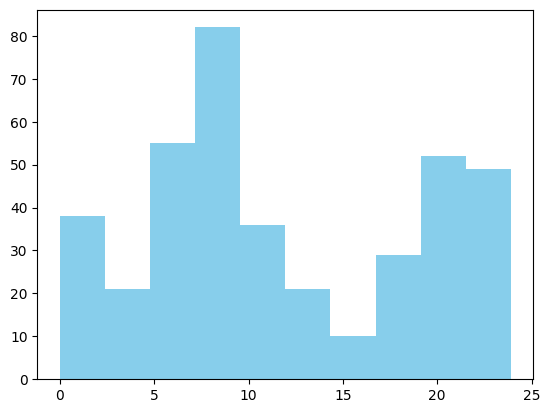

In [66]:
print(len(CT_df))
plt.hist(CT_df["LAG"], bins = 12, color = "skyblue")
# plt.savefig(figdir + "/count_ratio_phase_hist_all_new.SVG")
plt.xticks(np.arange(0,26,4))
#plt.yticks(np.arange(0,22,5))
plt.yticks(np.arange(0,82,20))
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
# plt.savefig(figdir + "/count_ratio_phase_hist_homo.SVG")
plt.savefig(figdir + "/count_ratio_phase_hist_all_new.SVG")
plt.show()

In [8]:
#filtering phase data by experimental batch and day

th = 0.1
ids, df_i, CT_norm = calc_CT_norm(CT_df, 0.1)  # all
# ids, df_i, CT_norm = calc_CT_norm_exp_day(CT_df, th, "1st", "1")
# ids, df_i, CT_norm = calc_CT_norm_exp_day(CT_df, th, "1st", "2")
# ids, df_i, CT_norm = calc_CT_norm_exp_day(CT_df, th, "2nd", "1")
# ids, df_i, CT_norm = calc_CT_norm_exp_day(CT_df, th, "2nd", "2")


CT_norm.shape

num of regions: 216


(216, 6)

In [28]:
#output of timetable

name = "1st_day1"
yl = 2.5

for i in range(6):
#     if i >0:
#         continue
    ph_li = CT_df["LAG"]/24
    ph_li = 1-ph_li
    ph_li = [(hue + 1/3 - 1) if (hue + 1/3) > 1 else (hue + 1/3) for hue in ph_li]
    colors = [hsv_to_rgb([i, 1, 1]) for i in ph_li]
    
    plt.figure(figsize=(6,4))

    plt.scatter(CT_df["LAG"], CT_norm[:,i], color = colors)
#     plt.title("CT"+str(i*4))
#     plt.xlabel("Peak time")
#     plt.ylabel("Normalized cell count ratio")
    plt.xticks(np.arange(0,28,4))
    plt.yticks(np.arange(-yl,yl+0.1,yl))
#     plt.yticks(np.arange(-1.5,0,1.5))
    plt.xlim(0,24)
    plt.ylim(-yl, yl)
    ax = plt.gca()
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    
    plt.savefig(figdir+"level_peak_time_cr_{}_homo.SVG".format(name+"_"+"CT"+str(i*4)))
    plt.show()
    
    #article
#     plt.figure(figsize=(6,4))
#     plt.scatter(CT_df["LAG"], CT_norm[:,i], color = colors)
#     plt.xlabel('',fontsize = fs)
#     plt.ylabel('', fontsize = fs)
#     plt.gca().spines['right'].set_visible(False)
#     plt.gca().spines['top'].set_visible(False)
#     plt.xlim(0,24)
#     plt.ylim()
    
#     ax = plt.gca()
#     ax.axes.xaxis.set_ticklabels([])
#     ax.axes.yaxis.set_ticklabels([])
#     plt.savefig(figdir+"level_peak_time_cr_{}.SVG".format("CT"+str(i*4)))
#     plt.show()

213

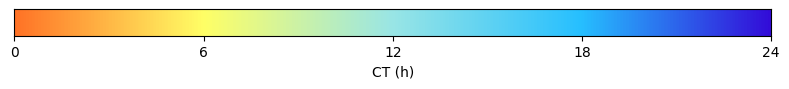

In [10]:
#blindness
# 1) ERDC IceFire + black + ダークレッド 制御点
control_points_mod_final = [
    (0.00, (1.00, 0.45, 0.15)),  # orange
    (0.25, (1.00, 1.00, 0.40)),  # yellowish
    (0.50, (0.60, 0.90, 0.90)),  # light cyan
    (0.75, (0.15, 0.75, 1.00)),  # cyan-blue
    (1.00, (0.20, 0.05, 0.85))   # blue-violet
]

cmap_icefire = LinearSegmentedColormap.from_list(
    "erdc_icefire_darkred",
    control_points_mod_final,
    N=256
)

fig, ax = plt.subplots(figsize=(8, 1.0))
grad = np.linspace(0, 1, 1200)[None, :]
ax.imshow(grad, aspect='auto', cmap=cmap_icefire, extent=[0, 24, 0, 1])
ax.set_yticks([])
ax.set_xlim(0, 24)
ax.set_xlabel("CT (h)")
ax.set_xticks([0, 6, 12, 18, 24])
plt.tight_layout()



# pdf_path_final = "/home/gpu_data/data8/kinoshita_cfos/bc_colorbar2.pdf"
# plt.savefig(pdf_path_final, bbox_inches="tight")
# plt.show()


In [ ]:
#output of timetable for blindness

name = "2nd_day1"
yl = 2.5
for i in range(6):
#     if i >0:
#         continue
    ph_li = CT_df["LAG"]/24
    # ph_li = 1-ph_li
    # ph_li = [(hue + 1/3 - 1) if (hue + 1/3) > 1 else (hue + 1/3) for hue in ph_li]
    rgba_float = cmap_icefire(np.array(ph_li)) #[cmap_icefire([i) for i in ph_li]
    # rgba_u8 = (rgba_float * 255).astype(np.uint8)   # shape=(N,4)
    colors = rgba_float[:, :3] 
    # colors = [hsv_to_rgb([i, 1, 1]) for i in ph_li]
    
    plt.figure(figsize=(6,4))

    plt.scatter(CT_df["LAG"], CT_norm[:,i], color = colors)
#     plt.title("CT"+str(i*4))
#     plt.xlabel("Peak time")
#     plt.ylabel("Normalized cell count ratio")
    plt.xticks(np.arange(0,28,4))
    plt.yticks(np.arange(-yl,yl+0.1,yl))
#     plt.yticks(np.arange(-1.5,0,1.5))
    plt.xlim(0,24)
    plt.ylim(-yl, yl)
    ax = plt.gca()
    plt.xlabel('')
    plt.ylabel('')
    ax = plt.gca()
    # plt.gca().spines['right'].set_visible(False)
    # plt.gca().spines['top'].set_visible(False)
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    
    plt.savefig(figdir_bc+"/level_peak_time_cr_{}_homo.SVG".format(name+"_"+"CT"+str(i*4)))
    plt.show()
    
    #article
#     plt.figure(figsize=(6,4))
#     plt.scatter(CT_df["LAG"], CT_norm[:,i], color = colors)
#     plt.xlabel('',fontsize = fs)
#     plt.ylabel('', fontsize = fs)
#     plt.gca().spines['right'].set_visible(False)
#     plt.gca().spines['top'].set_visible(False)
#     plt.xlim(0,24)
#     plt.ylim()
    
#     ax = plt.gca()
#     ax.axes.xaxis.set_ticklabels([])
#     ax.axes.yaxis.set_ticklabels([])
#     plt.savefig(figdir+"level_peak_time_cr_{}.SVG".format("CT"+str(i*4)))
#     plt.show()

In [ ]:
name = "all"
yl = 2.0
for i in range(6):
#     if i >0:
#         continue
    ph_li = CT_df["LAG"]/24
    ph_li = 1-ph_li
    ph_li = [(hue + 1/3 - 1) if (hue + 1/3) > 1 else (hue + 1/3) for hue in ph_li]
    colors = [hsv_to_rgb([i, 1, 1]) for i in ph_li]
    
    plt.figure(figsize=(6,4))

    plt.scatter(CT_df["LAG"], CT_norm[:,i], color = colors)
#     plt.title("CT"+str(i*4))
#     plt.xlabel("Peak time")
#     plt.ylabel("Normalized cell count ratio")
    plt.xticks(np.arange(0,28,4), fontsize =10)
    plt.yticks(np.arange(-yl,yl+0.1,yl), fontsize =10)
#     plt.yticks(np.arange(-1.5,0,1.5))
    plt.xlim(0,24)
    plt.ylim(-yl, yl)
    
    plt.savefig(figdir+"level_peak_time_cr_{}_homo.SVG".format(name+"_"+"CT"+str(i*4)))
    plt.show()
    

In [67]:
#predicting the brain time of indivisual one by using other 143 samples
exps =["1st", "2nd"]
offsets = [0,48]
op="_ai_fpr0.5"
a=1
predicted=[]
phase_li = []
for k, exp in enumerate(exps):
#     if k>0:
#         continue
    offset = offsets[k]
    for i, sample in enumerate(sample_names):
#         if i>0:
#             continue
        sample_names_p =[j for j in sample_names if j != sample]

        sample2 = "CT"+str(int(sample.split("_")[0][2:])+offset)+"_"+sample.split("_")[1]
        print(sample2)
        CT_df_re = CT_df.drop(sample2, axis=1)

        mi = CT_df_re.iloc[:, 9:].mean(axis=1)
        SDi = CT_df_re.iloc[:, 9:].std(axis=1)


        # df = pd.read_csv(savedir+exp+"/region_cell_intense{}/".format(op)+sample+"_"+"region_cell_intensity_summary.csv", index_col=0)
        df = CT_df.copy() #pd.read_excel("TableS7.xlsx")
        small_IDs = []
        for ind in ca.df_allen["ID"]:
            if ca.smallID_q(ind):
                small_IDs.append(ind)

        df=df[df["id"].isin(small_IDs)]

        sort_id = CT_df_re["id"].tolist()
        df = df.set_index('id').loc[sort_id].reset_index()

    #     fdr_i = CT_df["BH.Q"]
    #     x = 0.1-(fdr_i)
    #     w_i = 1/(1+np.exp(-(x)*100))
        vnorm = [(df[sample2].iloc[i]-mi.iloc[i])/SDi.iloc[i] for i in range(len(df))]
    #     vnorm = [(df["count_ratio"].iloc[i]-mi[i])/SDi[i] for i in range(len(df))]
        vnorm = np.array(vnorm)  #* (np.array(w_i))
        print(len(vnorm))
        cmax, phase = max_corr_fig(CT_df, vnorm, a, exp, sample)
        
        phase_li.append(phase)
        predicted.append(phase)

'CT92_06'

In [ ]:
#predicting the brain time of indivisual one by using other 143 samples for blindness
exps =["1st", "2nd"]
offsets = [0,48]
op="_ai_fpr0.5"
a=1
predicted=[]
phase_li = []
for k, exp in enumerate(exps):
#     if k>0:
#         continue
    offset = offsets[k]
    for i, sample in enumerate(sample_names):
#         if i>0:
#             continue
        sample_names_p =[j for j in sample_names if j != sample]

        sample2 = "CT"+str(int(sample.split("_")[0][2:])+offset)+"_"+sample.split("_")[1]
        print(sample2)
        CT_df_re = CT_df.drop(sample2, axis=1)

        mi = CT_df_re.iloc[:, 9:].mean(axis=1)
        SDi = CT_df_re.iloc[:, 9:].std(axis=1)


        # df = pd.read_csv(savedir+exp+"/region_cell_intense{}/".format(op)+sample+"_"+"region_cell_intensity_summary.csv", index_col=0)
        # df = pd.read_excel("TableS7.xlsx")
        df = CT_df.copy()
        small_IDs = []
        for ind in ca.df_allen["ID"]:
            if ca.smallID_q(ind):
                small_IDs.append(ind)

        df=df[df["id"].isin(small_IDs)]

        sort_id = CT_df_re["id"].tolist()
        df = df.set_index('id').loc[sort_id].reset_index()

    #     fdr_i = CT_df["BH.Q"]
    #     x = 0.1-(fdr_i)
    #     w_i = 1/(1+np.exp(-(x)*100))
        vnorm = [(df[sample2].iloc[i]-mi.iloc[i])/SDi.iloc[i] for i in range(len(df))]
    #     vnorm = [(df["count_ratio"].iloc[i]-mi[i])/SDi[i] for i in range(len(df))]
        vnorm = np.array(vnorm)  #* (np.array(w_i))
        print(len(vnorm))
        cmax, phase = max_corr_fig(CT_df, vnorm, a, exp, sample, True)
        
        phase_li.append(phase)
        predicted.append(phase)

231.2167825102806


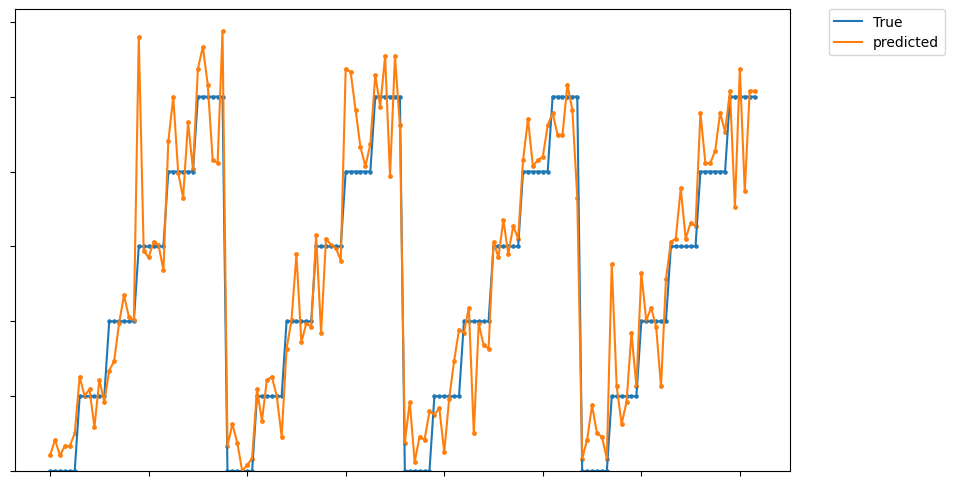

[0.83916086 1.67832172 0.83916086 1.34265733 1.34265733 2.01398611
 1.6223774  3.97202873 0.05594444 1.39860153 2.62936974 0.11188889
 1.4545455  0.05594444 3.58041954 1.11888123 0.11188793 0.27972031
 1.51048946 3.69230771 0.50349653 1.84615386 1.67832172 3.1888113 ]
[1.67832172 0.83916086 1.34265733 1.34265733 2.01398611 1.03496504
 3.97202873 0.05594444 1.39860153 2.62936974 0.11188889 1.48251724
 0.05594444 3.58041954 1.11888123 0.11188793 0.27972031 0.58741283
 3.69230771 0.50349653 1.84615386 1.67832172 3.1888113  0.97902107]
[0.83916086 1.34265733 1.34265733 2.01398611 1.03496504 0.02797222
 0.05594444 1.39860153 2.62936974 0.11188889 1.48251724 2.65734291
 3.58041954 1.11888123 0.11188793 0.27972031 0.58741283 4.61538458
 0.50349653 1.84615386 1.67832172 3.1888113  0.97902107 0.64335656]
[1.34265733 1.34265733 2.01398611 1.03496504 0.02797222 0.36363649
 1.39860153 2.62936974 0.11188889 1.48251724 2.65734291 0.64335632
 1.11888123 0.11188793 0.27972031 0.58741283 4.61538458 0.4

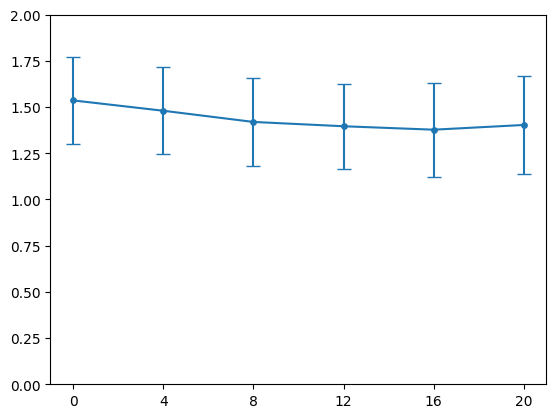

1.435508969757292

In [71]:
#calculate scores
score, min_diff = calc_score(sample_names+sample_names, predicted, True)
diff_plot(min_diff, True)

457.3986013829708


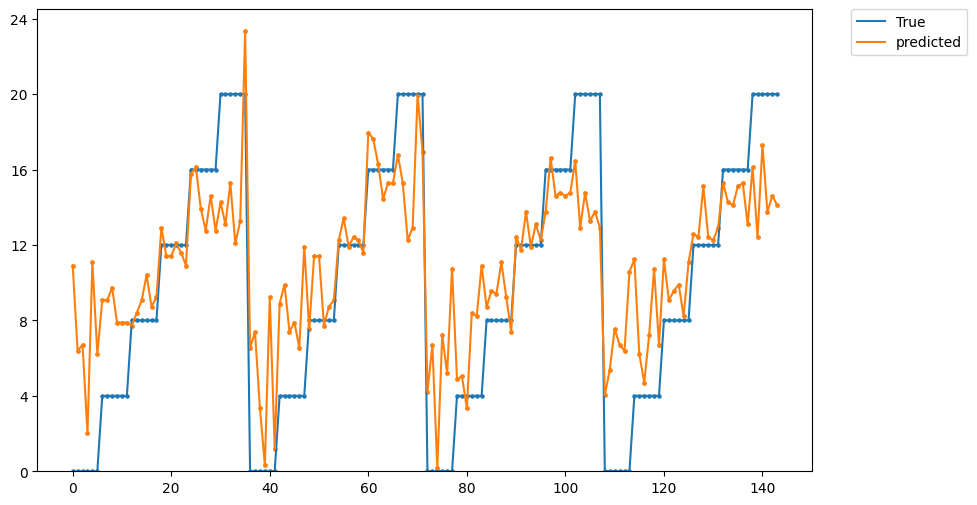

[10.909091    6.3776226   6.71328688  2.01398611 11.07692337  6.20979023
  0.22377586  0.11188889  2.06993008  3.24475479  1.39860153  3.24475479
  0.44755268  3.41258717  3.41258717  0.27972031  0.72727299  1.06293678
  4.19580412  6.71328688  0.16783217  7.21678305  5.20279741 10.74125862]
[ 6.3776226   6.71328688  2.01398611 11.07692337  6.20979023  5.06293678
  0.11188889  2.06993008  3.24475479  1.39860153  3.24475479  5.73426533
  3.41258717  3.41258717  0.27972031  0.72727299  1.06293678  0.25174809
  6.71328688  0.16783217  7.21678305  5.20279741 10.74125862  0.86713266]
[ 6.71328688  2.01398611 11.07692337  6.20979023  5.06293678  5.06293678
  2.06993008  3.24475479  1.39860153  3.24475479  5.73426533  6.909091
  3.41258717  0.27972031  0.72727299  1.06293678  0.25174809  1.42657375
  0.16783217  7.21678305  5.20279741 10.74125862  0.86713266  1.03496504]
[ 2.01398611 11.07692337  6.20979023  5.06293678  5.06293678  5.73426533
  3.24475479  1.39860153  3.24475479  5.73426533  

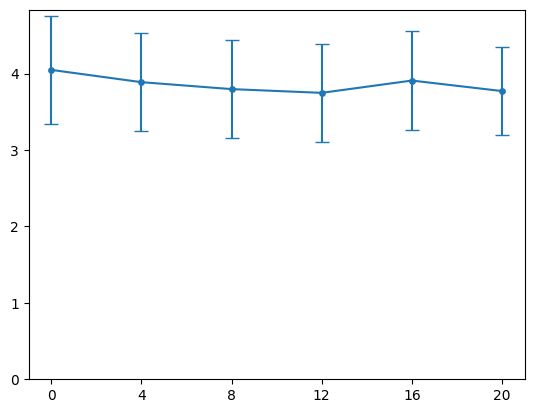

In [67]:
score, min_diff = calc_score(sample_names+sample_names, predicted)
diff_plot(min_diff)

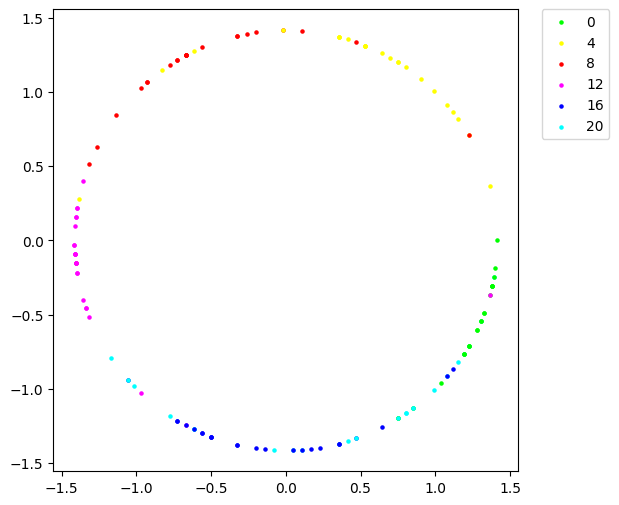

In [25]:
# projection mapping of results
CT_li = np.array([int(i.split("_")[0][2:]) for i in sample_names+sample_names])
ph_li = CT_li%24
ph_li = ph_li/24
ph_li = 1-ph_li
ph_li = [(hue + 1/3 - 1) if (hue + 1/3) > 1 else (hue + 1/3) for hue in ph_li]

x = np.array(amp_li) * np.cos(rads)
y = np.array(amp_li) * np.sin(rads)


plt.figure(figsize=(6, 6))
for i in range(len(x)):
    if i%6==0 and i <36:
        plt.scatter(x[i], y[i], s = 5, color = hsv_to_rgb([ph_li[i], 1, 1]), edgecolor=None, label=CT_li[i])  # 点としてプロット
    else:
        plt.scatter(x[i], y[i], s = 5, color = hsv_to_rgb([ph_li[i], 1, 1]), edgecolor=None) 
#     if i%6==0 and i<72:
#     plt.text(x[i], y[i], (sample_names+sample_names)[i], fontsize=9, ha='right')
# plt.title('Points arranged in a circular pattern')
# plt.xlabel('X')
# plt.ylabel('Y')
plt.xlim()
# plt.axis('')  # 均等なスケール
# plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig(figdir+"timetable_projection_annot.SVG")
plt.show()

       CT0_01    CT0_02    CT0_03    CT0_04    CT0_05    CT0_06    CT4_01  \
348  0.004746  0.004070  0.004990  0.005685  0.003670  0.004405  0.005419   
43   0.000122  0.000124  0.000115  0.000089  0.000105  0.000098  0.000160   
61   0.000247  0.000229  0.000328  0.000115  0.000147  0.000205  0.000170   
360  0.000061  0.000067  0.000094  0.000055  0.000047  0.000055  0.000045   
358  0.010497  0.012546  0.012451  0.017951  0.010105  0.010896  0.016888   
..        ...       ...       ...       ...       ...       ...       ...   
160  0.000629  0.000522  0.000590  0.000791  0.000457  0.000530  0.000601   
338  0.000449  0.000678  0.000657  0.001088  0.000816  0.000923  0.000554   
265  0.000080  0.000045  0.000040  0.000024  0.000012  0.000028  0.000023   
232  0.001389  0.001514  0.001810  0.001452  0.001118  0.001168  0.001530   
48   0.001033  0.000951  0.001162  0.001001  0.000758  0.001096  0.001104   

       CT4_02    CT4_03    CT4_04  ...   CT88_03   CT88_04   CT88_05  \
348

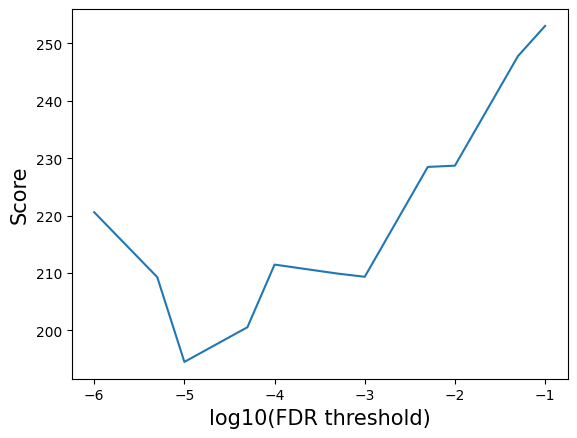

In [74]:
#timetable method in different FDR threshold

FDR_li = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001, 0.000005, 0.000001]

op = "_ai_fpr0.5"
exps =["1st", "2nd"]
offsets = [0,48]
a=1

jtkdir = "/mnt/gpu_data/data1/kinoshita/JTK_results/"
res = "cos.cell_count_ratio_1st2nd_small_ai_fpr0.5_0.0375.csv"

CT_df = pd.read_csv(jtkdir+res)

acronyms =[]
nodes =[]

CT_df = CT_df.drop(["Unnamed: 0"], axis=1)


scores=[]
mean_diff_li=[]
region_nums = []
for FDR_th in FDR_li:
    CT_df2 = CT_df[CT_df["BH.Q"]< FDR_th]
    CT_df2 = CT_df2.sort_values("LAG")
    region_nums.append(len(CT_df2))
    print(CT_df2.iloc[:, 9:])

    ids, df_i, CT_norm = calc_CT_norm(CT_df2, FDR_th)
    
    mi = CT_df2.iloc[:, 9:].mean(axis=1)
    SDi = CT_df2.iloc[:, 9:].std(axis=1)

    minv = CT_df2.iloc[:, 9:].min(axis=1)
    maxv = CT_df2.iloc[:, 9:].max(axis=1)



    a = 1#np.max(w_i)

 
    predicted=[]
    phase_li = []
    for k, exp in enumerate(exps):
    #     if k>0:
    #         continue
        offset = offsets[k]
        for i, sample in enumerate(sample_names):
        #     if i>0:
        #         continue
            sample_names_p =[j for j in sample_names if j != sample]

            sample2 = "CT"+str(int(sample.split("_")[0][2:])+offset)+"_"+sample.split("_")[1]
            print(sample2)
            CT_df_re = CT_df2.drop(sample2, axis=1)

            mi = CT_df_re.iloc[:, 9:].mean(axis=1)
            SDi = CT_df_re.iloc[:, 9:].std(axis=1)


            # df = pd.read_csv(savedir+exp+"/region_cell_intense{}/".format(op)+sample+"_"+"region_cell_intensity_summary.csv", index_col=0)
            df = pd.read_excel("TableS7.xlsx")
            small_IDs = []
            for ind in ca.df_allen["ID"]:
                if ca.smallID_q(ind):
                    small_IDs.append(ind)

            df=df[df["id"].isin(small_IDs)]

            sort_id = CT_df_re["id"].tolist()
            df = df.set_index('id').loc[sort_id].reset_index()
            


        #     fdr_i = CT_df["BH.Q"]
        #     x = 0.1-(fdr_i)
        #     w_i = 1/(1+np.exp(-(x)*100))
            # vnorm = [(df["count_ratio"].iloc[i]-mi.iloc[i])/SDi.iloc[i] for i in range(len(df))]
            vnorm = [(df[sample2].iloc[i]-mi.iloc[i])/SDi.iloc[i] for i in range(len(df))]
        #     vnorm = [(df["count_ratio"].iloc[i]-mi[i])/SDi[i] for i in range(len(df))]
        
            vnorm = np.nan_to_num(vnorm)
            vnorm = vnorm[vnorm != 0]#np.nan_to_num(vnorm)
            CT_df_d =CT_df2.iloc[np.where(vnorm != 0)[0]]
            vnorm = np.array(vnorm)  #* (np.array(w_i))
            cmax, phase = max_corr_nofig(CT_df_d, vnorm, a, exp, sample)

            phase_li.append(phase)
            predicted.append(phase)

    print(FDR_th)
    score, min_diff= calc_score(sample_names+sample_names, predicted)
    
    scores.append(score)
    mean_diff = diff_plot(min_diff)
    
    mean_diff_li.append(mean_diff)
    
    
plt.plot(np.log10(FDR_li), scores)
plt.xlabel("log10(FDR threshold)",fontsize = 15)
plt.ylabel("Score",fontsize = 15)
plt.show()


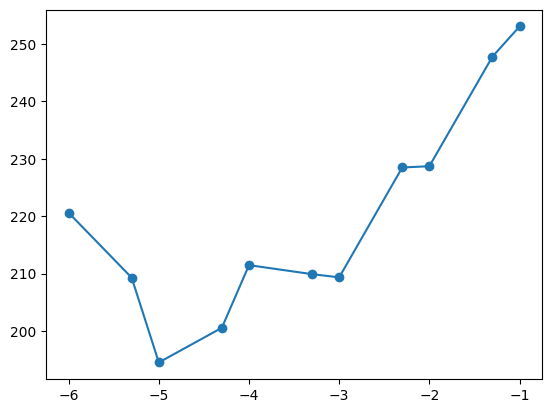

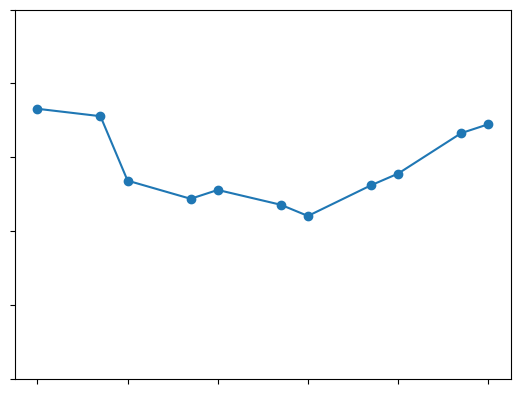

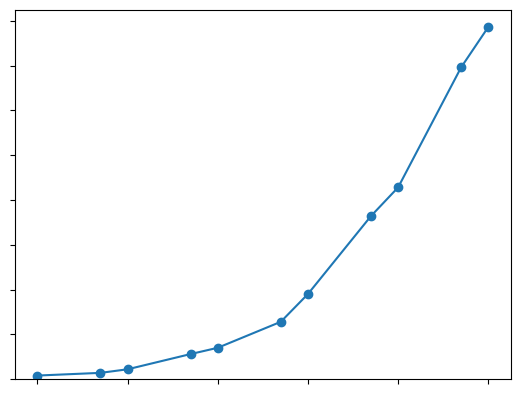

In [80]:
    
plt.plot(np.log10(FDR_li)[::-1], scores[::-1])
plt.scatter(np.log10(FDR_li)[::-1], scores[::-1])
# plt.xlabel("log10(FDR threshold)",fontsize = fs)
# plt.ylabel("Score",fontsize = fs)
# plt.xlabel("log10(FDR threshold)",fontsize = fs)
# plt.ylabel("Score",fontsize = fs)
# ax = plt.gca()
# ax.axes.xaxis.set_ticklabels([])
# ax.axes.yaxis.set_ticklabels([])
plt.savefig(figdir + "timetable_FDR_score.SVG")
plt.show()

plt.plot(np.log10(FDR_li)[::-1], mean_diff_li[::-1])
plt.scatter(np.log10(FDR_li)[::-1], mean_diff_li[::-1])
# plt.xlabel("log10(FDR threshold)",fontsize = fs)
# plt.ylabel("Score",fontsize = fs)
plt.yticks(np.arange(0, 3, 0.5))
plt.ylim(0,)
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

plt.savefig(figdir + "timetable_FDR_mean_diff.SVG")
plt.show()

    
plt.plot(np.log10(FDR_li)[::-1], region_nums[::-1])
plt.scatter(np.log10(FDR_li)[::-1], region_nums[::-1])
# plt.ylabel("Number of regions",fontsize = fs)
# plt.xlabel("log10(FDR threshold)",fontsize = fs)
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
plt.ylim(0,)
plt.savefig(figdir + "timetable_FDR_region_num.SVG")
plt.show()



In [18]:
#obtain c_th by sample -> average corr threshold
N=10000
ncore = 30
mn = 1
cmax_i_li = np.arange(0, 1.0, 0.01)
bs=np.linspace(0, 24, 144) 
FDR_li = [0.0001]#,#0.1 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001, 0.000005, 0.000001]
# exp_rs = [ '1st', '2nd', '2nd', '2nd', '2nd']
# sample_names_rs = [ 'CT32_06', 'CT36_06', 'CT12_06', 'CT44_04', 'CT40_02']

op = "_ai_fpr0.5"
# exps =["1st", "2nd"]
# offsets = [0,48]
a=1

jtkdir = "/mnt/gpu_data/data1/kinoshita/JTK_results/"
res = "cos.cell_count_ratio_1st2nd_small_ai_fpr0.5_0.0375.csv"

CT_df = pd.read_csv(jtkdir+res)

acronyms =[]
nodes =[]

CT_df = CT_df.drop(["Unnamed: 0"], axis=1)

scores=[]
mean_diff_li=[]
region_nums = []

#random sampling
exp_rs = []
sample_names_rs = []
Nr = 10
for i in range(Nr):
    sample_r = random.choice(list((CT_df.iloc[:, 9:]).columns))
    print(sample_r)
    if int(sample_r.split("_")[0][2:]) > 44:
        exp_rs.append("2nd")
        sample_names_rs.append("CT"+str(int(sample_r.split("_")[0][2:])-48)+"_"+sample_r.split("_")[1])
    else:
        exp_rs.append("1st")
        sample_names_rs.append(sample_r)

print(exp_rs)
print(sample_names_rs)


#calc average th
for FDR_th in FDR_li:
    CT_df2 = CT_df[CT_df["BH.Q"]< FDR_th]
    CT_df2 = CT_df2.sort_values("LAG")
    region_nums.append(len(CT_df2))
    print(len(CT_df2))

#     ids, df_i, CT_norm = calc_CT_norm(CT_df2, FDR_th)
    
   
#     minv = CT_df2.iloc[:, 9:].min(axis=1)
#     maxv = CT_df2.iloc[:, 9:].max(axis=1)
    
    c_ths = []

    predicted=[]
    phase_li = []
    cmax_li = []
    for k, (exp, sample) in enumerate(zip(exp_rs, sample_names_rs)):
#         if k>0:
#             continue
#         print(exp)
            if exp == "2nd":
                offset = 48
            else:
                offset = 0

    
            sample_names_p =[j for j in sample_names if j != sample]

            sample2 = "CT"+str(int(sample.split("_")[0][2:])+offset)+"_"+sample.split("_")[1]
            print(sample2)
            CT_df_re = CT_df2.drop(sample2, axis=1)

            mi = CT_df_re.iloc[:, 9:].mean(axis=1)
            SDi = CT_df_re.iloc[:, 9:].std(axis=1)


            # df = pd.read_csv(savedir+exp+"/region_cell_intense{}/".format(op)+sample+"_"+"region_cell_intensity_summary.csv", index_col=0)
            df = pd.read_excel("TableS7.xlsx")
            small_IDs = []
            for ind in ca.df_allen["ID"]:
                if ca.smallID_q(ind):
                    small_IDs.append(ind)

            df=df[df["id"].isin(small_IDs)]

            sort_id = CT_df_re["id"].tolist()
            df = df.set_index('id').loc[sort_id].reset_index()
            

            vnorm = [(df[sample2].iloc[i]-mi.iloc[i])/SDi.iloc[i] for i in range(len(df))]
            vnorm = np.nan_to_num(vnorm)
            vnorm = vnorm[vnorm != 0]#np.nan_to_num(vnorm)
            CT_df_d =CT_df2.iloc[np.where(vnorm != 0)[0]]
            vnorm = np.array(vnorm)  #* (np.array(w_i))
            
            peakt = np.array(CT_df_d["LAG"])
            
            corrs = []
            for b in bs:

                cos_p = np.sqrt(2)*np.cos(2*np.pi*(peakt-b)/24)
                corr, p = pearsonr(vnorm, cos_p)
                corrs.append(corr)

            bc = bs[np.argmax(corrs)]
            cmax = np.max(corrs)
            
#             os.makedirs(savedir+"timetable/timetable_corrmax_fdr{}/".format(FDR_th)+exp+"/", exist_ok=True)
            
#             f=open(savedir+"timetable/timetable_corrmax_fdr{}/".format(FDR_th)+exp+"/"+sample+".txt", "w")
#             f.write(str(cmax)+"\n")
#             f.write(str(bc))
#             f.close()
            
            cmax_li.append(cmax)
#             print(bc)
#             print(cmax)
            
            
            di_li = vnorm - np.sqrt(2)*np.cos(2*np.pi*(peakt-bc)/24)
#             print(np.std(di_li)*100)

            

            cmaxs_c = multi_cont_dis(N, mn, peakt, di_li, ncore)#cont_pro_dis(N, mn, peakt, di_li)
            cmaxs_r =multi_rand_dis(N, mn, peakt, vnorm, ncore) # rand_pro_dis(N, mn, peakt, vnorm)

            Sc_li = np.zeros(len(cmax_i_li), dtype="float32")
            Sr_li= np.zeros(len(cmax_i_li), dtype="float32")


            for j, cmax_i in enumerate(cmax_i_li):
                Pr = get_pv_r(cmax_i, cmaxs_r)
                Pc = get_pv_c(cmax_i, cmaxs_c)

                Sc = 1 - Pc  #sensitivity
                Sr = 1 - Pr  #specificity

                Sr_li[j] = Sr
                Sc_li[j] = Sc


            min_in = np.argmin(np.abs(Sc_li-Sr_li))
            c_th = cmax_i_li[min_in]
            os.makedirs(savedir+"timetable2/timetable_corrth_fdr{}/".format(FDR_th)+exp+"/", exist_ok=True)
            f=open(savedir+"timetable2/timetable_corrth_fdr{}/".format(FDR_th)+exp+"/"+sample+".txt", "w")
            f.write(str(c_th)+"\n")
            f.close()
            
            c_ths.append(c_th)
            print("fdr{}_{}_{}_c_th: {}".format(FDR_th, exp, sample, c_th))
    c_th_ave = np.mean(c_ths)
    print("fdr{}_c_th_average: {}".format(FDR_th, c_th_ave))


CT56_05
CT4_04
CT16_02
CT20_05
CT68_02
CT80_01
CT92_04
CT20_03
CT36_04
CT72_05
['2nd', '1st', '1st', '1st', '2nd', '2nd', '2nd', '1st', '1st', '2nd']
['CT8_05', 'CT4_04', 'CT16_02', 'CT20_05', 'CT20_02', 'CT32_01', 'CT44_04', 'CT20_03', 'CT36_04', 'CT24_05']
393
CT56_05
fdr0.1_2nd_CT8_05_c_th: 0.19
CT4_04
fdr0.1_1st_CT4_04_c_th: 0.21
CT16_02
fdr0.1_1st_CT16_02_c_th: 0.22
CT20_05
fdr0.1_1st_CT20_05_c_th: 0.21
CT68_02
fdr0.1_2nd_CT20_02_c_th: 0.19
CT80_01
fdr0.1_2nd_CT32_01_c_th: 0.23
CT92_04
fdr0.1_2nd_CT44_04_c_th: 0.23
CT20_03
fdr0.1_1st_CT20_03_c_th: 0.21
CT36_04
fdr0.1_1st_CT36_04_c_th: 0.21
CT72_05
fdr0.1_2nd_CT24_05_c_th: 0.22
fdr0.1_c_th_average: 0.21200000000000002


In [51]:
# FDR0.1   
# c_th_ave  = 0.089
#FDR0.05
#  c_th_ave  = 0.24
#FDR 0.01
# c_th_ave  = 0.30999999999999

#FDR 0.005
#c_th_ave  = 0.324

#FDR 0.001#
# c_th_ave = 0.442

#FDR 0.0005
# c_th_ave = 0.483


#FDR 0.0001
# c_th_ave=0.59000000

#FRD 0.00005
# c_th_ave=0.624

#0.00001
# c_th_ave=0.741

#FDR 0.000005
#c_th_ave = 0.867

# 0.000001
# c_th_ave = 0.976

c_ths = []


c_th_ave = np.mean(c_ths)
print(c_th_ave)

0.324


In [25]:
#% of c_th > -> sensitivity, specificity auto
op = "_ai_fpr{}".format(0.5)

FDR_th_li = [0.1, 0.05, 0.01, 0.005,   0.001, 0.0005,0.0001,0.00005, 0.00001, 0.000005, 0.000001]
c_th_ave_li =  []



sens = []
spec = []

exps =["1st", "2nd"]
offsets = [0, 48]
bs=np.linspace(0, 24, 144) 

jtkdir = "/mnt/gpu_data/data1/kinoshita/JTK_results/"
res = "cos.cell_count_ratio_1st2nd_small_ai_fpr0.5_0.0375.csv"

CT_df = pd.read_csv(jtkdir+res)


for FDR_th, c_th_ave in zip(FDR_th_li, c_th_ave_li):
    predicted=[]
    phase_li = []
    cmax_li = []
    plus_c = 0
    random_c = 0
    CT_df2 = CT_df[CT_df["BH.Q"]< FDR_th]
    CT_df2 = CT_df2.sort_values("LAG")
    
    for k, exp in enumerate(exps):
    #     if k>0:
    #         continue
        offset = offsets[k]
        for i, sample in enumerate(sample_names):
    #         if i==0:
    #             continue
            sample_names_p =[j for j in sample_names if j != sample]
    
            sample2 = "CT"+str(int(sample.split("_")[0][2:])+offset)+"_"+sample.split("_")[1]
            print(sample2)
            CT_df_re = CT_df2.drop(sample2, axis=1)
    
            mi = CT_df_re.iloc[:, 9:].mean(axis=1)
            SDi = CT_df_re.iloc[:, 9:].std(axis=1)
    
    
            # df = pd.read_csv(savedir+exp+"/region_cell_intense{}/".format(op)+sample+"_"+"region_cell_intensity_summary.csv", index_col=0)
            df = pd.read_excel("TableS7.xlsx")
            
            small_IDs = []
            for ind in ca.df_allen["ID"]:
                if ca.smallID_q(ind):
                    small_IDs.append(ind)
    
            df=df[df["id"].isin(small_IDs)]
    
            sort_id = CT_df_re["id"].tolist()
            df = df.set_index('id').loc[sort_id].reset_index()
    

            # vnorm = [(df["count_ratio"].iloc[i]-mi.iloc[i])/SDi.iloc[i] for i in range(len(df))]
            
            vnorm = [(df[sample2].iloc[i]-mi.iloc[i])/SDi.iloc[i] for i in range(len(df))]
        #
            vnorm = np.nan_to_num(vnorm)
            vnorm = vnorm[vnorm != 0]#np.nan_to_num(vnorm)
            CT_df_d =CT_df2.iloc[np.where(vnorm != 0)[0]]
            vnorm = np.array(vnorm)  #* (np.array(w_i))
    
            peakt = np.array(CT_df_d["LAG"])
    
            corrs = []
            for b in bs:
    
                cos_p = np.sqrt(2)*np.cos(2*np.pi*(peakt-b)/24)
                corr, p = pearsonr(vnorm, cos_p)
                corrs.append(corr)
    
            bc = bs[np.argmax(corrs)]
            cmax = np.max(corrs)
            print(cmax)
            
            if cmax > c_th_ave:
                plus_c += 1
            
            
            #specificity
            
            vnorm_r = vnorm.copy()#np.random.uniform(low=-2.5, high=2.5, size=(vnorm.shape[0], vnorm.shape[1]))
            np.random.shuffle(vnorm_r)
            corrs_r = []
            for b in bs:
    
                cos_p = np.sqrt(2)*np.cos(2*np.pi*(peakt-b)/24)
                corr, p = pearsonr(vnorm_r, cos_p)
                corrs_r.append(corr)
    
            bc_r = bs[np.argmax(corrs_r)]
            cmax_r = np.max(corrs_r)
            print("random", cmax_r)
            
            if cmax_r < c_th_ave:
                random_c += 1
            
            
            
    #         plt.figure(figsize=(6,4))
    
    #         yl=2.5
    
    
    
    #         ph_li = CT_df_d["LAG"]/24
    #         ph_li = 1-ph_li
    #         ph_li = [(hue + 1/3 - 1) if (hue + 1/3) > 1 else (hue + 1/3) for hue in ph_li]
    #         colors = [hsv_to_rgb([i, 1, 1]) for i in ph_li]
    
    #         plt.scatter(CT_df_d["LAG"], vnorm, c=colors)
    
    #         plt.plot(CT_df_d["LAG"],  np.sqrt(2)*np.cos(2*np.pi*(peakt-bc)/24), color = "k")
    #         plt.xticks(np.arange(0,28,4))
    
    #         plt.yticks(np.arange(-yl,yl+0.1,yl))
    #         plt.xlim(0,24)
    #         plt.ylim(-yl,yl)
    
    #         plt.show()
            
            
                
    per_sens = (plus_c/(len(sample_names)*2)) * 100 
    per_spec = (random_c/(len(sample_names)*2)) * 100 
    # per_sens_li.append(per_sens)
    print("FDR{}, sensitivity:{}%".format(FDR_th, per_sens))
    print("FDR{}, specificity:{}%".format(FDR_th, per_spec))

    sens.append(per_sens)
    spec.append(per_spec)

CT0_01
0.21175034933536088
random 0.06980921621158266
CT0_02
0.3420704619517832
random 0.05362207586668794
CT0_03
0.3752145341681045
random 0.06402032675869485
CT0_04
0.34862930086789484
random 0.00859211871900774
CT0_05
0.17492557575356243
random 0.023451366023457484
CT0_06
0.35216758948057847
random 0.020427162259312067
CT4_01
0.2754352459031501
random 0.037451760996243554
CT4_02
0.08582734817744522
random 0.07342177128512128
CT4_03
0.26374528459474206
random 0.061100677748538
CT4_04
0.22726757768459244
random 0.09903434839488279
CT4_05
0.1381716501538076
random 0.09103470867181043
CT4_06
0.24442442222638788
random 0.04625376563033085
CT8_01
0.154603617214048
random 0.07886459603505412
CT8_02
0.14645763724012448
random 0.02437361821600673
CT8_03
0.27611659240132336
random 0.08933829882498867
CT8_04
0.2840295014253039
random 0.014497625774782016
CT8_05
0.27882067147317263
random 0.08887940341326586
CT8_06
0.3497748874414989
random 0.05087969861726356
CT12_01
0.1943887199317122
random 

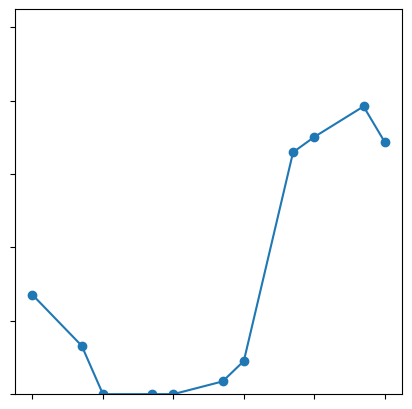

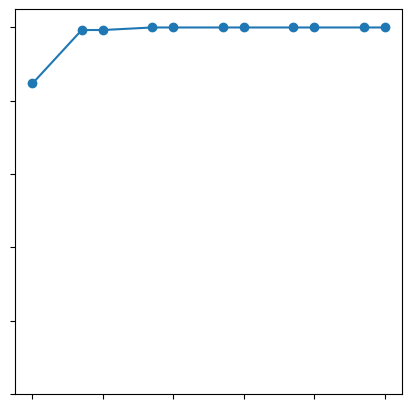

In [26]:
# plot Sensitivity  and Specificity

plt.figure(figsize=(5,5))
plt.plot(np.log10(FDR_th_li)[::-1], sens[::-1])
plt.scatter(np.log10(FDR_th_li)[::-1], sens[::-1])
# plt.xlabel("log10(FDR threshold)",fontsize = fs)
# plt.ylabel("Score",fontsize = fs)
plt.xticks(np.arange(-6, -0.9, 1))
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
plt.ylim(0,105)
# plt.savefig(figdir + "timetable_FDR_sensitivity.SVG")
plt.show()


plt.figure(figsize=(5,5))
plt.plot(np.log10(FDR_th_li)[::-1], spec[::-1])
plt.scatter(np.log10(FDR_th_li)[::-1], spec[::-1])
# plt.xlabel("log10(FDR threshold)",fontsize = fs)
# plt.ylabel("Score",fontsize = fs)
plt.xticks(np.arange(-6, -0.9, 1))
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
plt.ylim(0,105)
# plt.savefig(figdir + "timetable_FDR_specificity.SVG")
plt.show()

In [81]:
#% of c_th > -> sensitivity, specificity by CTs
op = "_ai_fpr{}_".format(0.5)
FDR_th=0.1#0.005#0.01#0.1 #0.05
c_th_ave =0.089 #0.24#  0.324#0.30999999999999#0.089  #0.24

jtkdir = "/mnt/gpu_data/data1/kinoshita/JTK_results/"
res = "cos.cell_count_ratio_1st2nd_small_ai_fpr0.5_0.0375.csv"

CT_df = pd.read_csv(jtkdir+res)
CT_df2 = CT_df[CT_df["BH.Q"]< FDR_th]
CT_df2 = CT_df2.sort_values("LAG")

exps =["1st", "2nd"]
offsets = [0, 48]
bs=np.linspace(0, 24, 144)
predicted=[]
phase_li = []
cmax_li = []
# plus_c = 0
# random_c = 0

CT_c_c = {"0":0, "4":0, "8":0, "12":0, "16":0, "20":0}   #
CT_r_c = {"0":0, "4":0, "8":0, "12":0, "16":0, "20":0} 

for k, exp in enumerate(exps):
#     if k>0:
#         continue
    offset = offsets[k]
    for i, sample in enumerate(sample_names):
#         if i==0:
#             continue
        sample_names_p =[j for j in sample_names if j != sample]

        sample2 = "CT"+str(int(sample.split("_")[0][2:])+offset)+"_"+sample.split("_")[1]
        print(sample2)
        CT_df_re = CT_df2.drop(sample2, axis=1)

        mi = CT_df_re.iloc[:, 9:].mean(axis=1)
        SDi = CT_df_re.iloc[:, 9:].std(axis=1)


        # df = pd.read_csv(savedir+exp+"/region_cell_intense{}/".format(op)+sample+"_"+"region_cell_intensity_summary.csv", index_col=0)
        df = pd.read_excel("TableS7.xlsx")

        
        
        small_IDs = []
        for ind in ca.df_allen["ID"]:
            if ca.smallID_q(ind):
                small_IDs.append(ind)

        df=df[df["id"].isin(small_IDs)]

        sort_id = CT_df_re["id"].tolist()
        df = df.set_index('id').loc[sort_id].reset_index()



    #     fdr_i = CT_df["BH.Q"]
    #     x = 0.1-(fdr_i)
    #     w_i = 1/(1+np.exp(-(x)*100))
        vnorm = [(df[sample2].iloc[i]-mi.iloc[i])/SDi.iloc[i] for i in range(len(df))]
    #     vnorm = [(df["count_ratio"].iloc[i]-mi[i])/SDi[i] for i in range(len(df))]
        vnorm = np.nan_to_num(vnorm)
        vnorm = vnorm[vnorm != 0]#np.nan_to_num(vnorm)
        CT_df_d =CT_df2.iloc[np.where(vnorm != 0)[0]]
        vnorm = np.array(vnorm)  #* (np.array(w_i))

        peakt = np.array(CT_df_d["LAG"])

        corrs = []
        for b in bs:

            cos_p = np.sqrt(2)*np.cos(2*np.pi*(peakt-b)/24)
            corr, p = pearsonr(vnorm, cos_p)
            corrs.append(corr)

        bc = bs[np.argmax(corrs)]
        cmax = np.max(corrs)
        # print("cmax", cmax)
        
        if cmax > c_th_ave:

            if int(sample.split("_")[0][2:])% 24 == 0:
                CT_c_c["0"] += 1
            elif int(sample.split("_")[0][2:])% 24 == 4:
                CT_c_c["4"] += 1
            elif int(sample.split("_")[0][2:])% 24 == 8:
                CT_c_c["8"] += 1
            elif int(sample.split("_")[0][2:])% 24 == 12:
                CT_c_c["12"] += 1
            elif int(sample.split("_")[0][2:])% 24 == 16:
                CT_c_c["16"] += 1
            elif int(sample.split("_")[0][2:])% 24 == 20:
                CT_c_c["20"] += 1
        
        
        #specificity
        
        vnorm_r = vnorm.copy()#np.random.uniform(low=-2.5, high=2.5, size=(vnorm.shape[0], vnorm.shape[1]))
        np.random.shuffle(vnorm_r)
        corrs_r = []
        for b in bs:

            cos_p = np.sqrt(2)*np.cos(2*np.pi*(peakt-b)/24)
            corr, p = pearsonr(vnorm_r, cos_p)
            corrs_r.append(corr)

        bc_r = bs[np.argmax(corrs_r)]
        cmax_r = np.max(corrs_r)
        # print("random_cmax_r", cmax_r)
        
        if cmax_r < c_th_ave:
            if int(sample.split("_")[0][2:])% 24 == 0:
                CT_r_c["0"] += 1
            elif int(sample.split("_")[0][2:])% 24 == 4:
                CT_r_c["4"] += 1
            elif int(sample.split("_")[0][2:])% 24 == 8:
                CT_r_c["8"] += 1
            elif int(sample.split("_")[0][2:])% 24 == 12:
                CT_r_c["12"] += 1
            elif int(sample.split("_")[0][2:])% 24 == 16:
                CT_r_c["16"] += 1
            elif int(sample.split("_")[0][2:])% 24 == 20:
                CT_r_c["20"] += 1
        
            # random_c += 1
        
        
        
#         plt.figure(figsize=(6,4))

#         yl=2.5



#         ph_li = CT_df_d["LAG"]/24
#         ph_li = 1-ph_li
#         ph_li = [(hue + 1/3 - 1) if (hue + 1/3) > 1 else (hue + 1/3) for hue in ph_li]
#         colors = [hsv_to_rgb([i, 1, 1]) for i in ph_li]

#         plt.scatter(CT_df_d["LAG"], vnorm, c=colors)

#         plt.plot(CT_df_d["LAG"],  np.sqrt(2)*np.cos(2*np.pi*(peakt-bc)/24), color = "k")
#         plt.xticks(np.arange(0,28,4))

#         plt.yticks(np.arange(-yl,yl+0.1,yl))
#         plt.xlim(0,24)
#         plt.ylim(-yl,yl)

#         plt.show()

CT_sens = [v/24*100 for k, v in CT_c_c.items()]
CT_spec = [v/24*100 for k, v in CT_r_c.items()]
        
        
            
# per_sens = (plus_c/(len(sample_names)*2)) * 100 
# per_spec = (random_c/(len(sample_names)*2)) * 100 
# per_sens_li.append(per_sens)
print("FDR{}, sensitivity:{}%".format(FDR_th, CT_sens))
print("FDR{}, specificity:{}%".format(FDR_th, CT_spec))


 # plt.plot(CT_df_d["LAG"],  np.sqrt(2)*np.cos(2*np.pi*(peakt-bc)/24), color = "k")
#         plt.xticks(np.arange(0,28,4))

#         plt.yticks(np.arange(-yl,yl+0.1,yl))
#         plt.xlim(0,24)
#         plt.ylim(-yl,yl)

#         plt.show()

CT0_01
CT0_02
CT0_03
CT0_04
CT0_05
CT0_06
CT4_01
CT4_02
CT4_03
CT4_04
CT4_05
CT4_06
CT8_01
CT8_02
CT8_03
CT8_04
CT8_05
CT8_06
CT12_01
CT12_02
CT12_03
CT12_04
CT12_05
CT12_06
CT16_01
CT16_02
CT16_03
CT16_04
CT16_05
CT16_06
CT20_01
CT20_02
CT20_03
CT20_04
CT20_05
CT20_06
CT24_01
CT24_02
CT24_03
CT24_04
CT24_05
CT24_06
CT28_01
CT28_02
CT28_03
CT28_04
CT28_05
CT28_06
CT32_01
CT32_02
CT32_03
CT32_04
CT32_05
CT32_06
CT36_01
CT36_02
CT36_03
CT36_04
CT36_05
CT36_06
CT40_01
CT40_02
CT40_03
CT40_04
CT40_05
CT40_06
CT44_01
CT44_02
CT44_03
CT44_04
CT44_05
CT44_06
CT48_01
CT48_02
CT48_03
CT48_04
CT48_05
CT48_06
CT52_01
CT52_02
CT52_03
CT52_04
CT52_05
CT52_06
CT56_01
CT56_02
CT56_03
CT56_04
CT56_05
CT56_06
CT60_01
CT60_02
CT60_03
CT60_04
CT60_05
CT60_06
CT64_01
CT64_02
CT64_03
CT64_04
CT64_05
CT64_06
CT68_01
CT68_02
CT68_03
CT68_04
CT68_05
CT68_06
CT72_01
CT72_02
CT72_03
CT72_04
CT72_05
CT72_06
CT76_01
CT76_02
CT76_03
CT76_04
CT76_05
CT76_06
CT80_01
CT80_02
CT80_03
CT80_04
CT80_05
CT80_06
CT84_01
CT

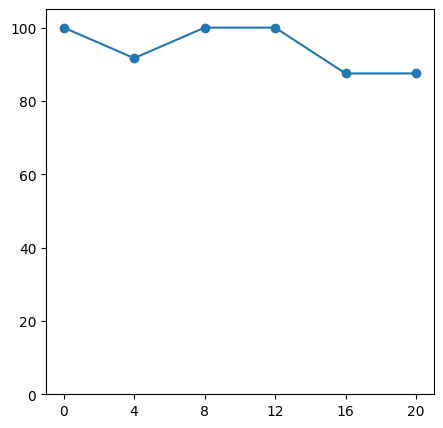

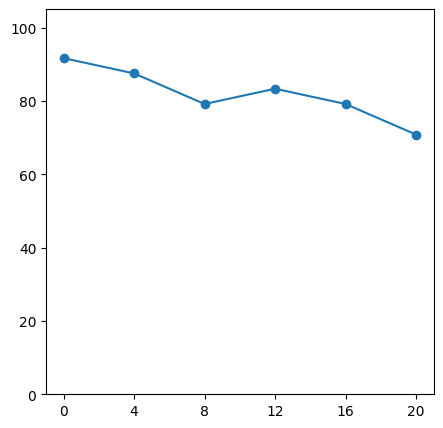

In [82]:
plt.figure(figsize=(5,5))
plt.plot(list(CT_c_c.keys()), CT_sens)
plt.scatter(list(CT_c_c.keys()), CT_sens)
# plt.xlabel("log10(FDR threshold)",fontsize = fs)
# plt.ylabel("Score",fontsize = fs)
ax = plt.gca()
# ax.axes.xaxis.set_ticklabels([])
# ax.axes.yaxis.set_ticklabels([])
plt.ylim(0,105)
plt.savefig(figdir + "timetable_FDR{}_sensitivity_byCT.SVG".format(FDR_th))
plt.show()


plt.figure(figsize=(5,5))
plt.plot(list(CT_c_c.keys()), CT_spec)
plt.scatter(list(CT_c_c.keys()), CT_spec)
# plt.xlabel("log10(FDR threshold)",fontsize = fs)
# plt.ylabel("Score",fontsize = fs)
ax = plt.gca()
# ax.axes.xaxis.set_ticklabels([])
# ax.axes.yaxis.set_ticklabels([])
plt.ylim(0,105)
plt.savefig(figdir + "timetable_FDR{}_specificity_byCT.SVG".format(FDR_th))
plt.show()